# Exploratory Data Analysis

## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import string
import numpy as np
import nltk
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import ConfusionMatrixDisplay
import sys
import os
import re
import swifter
import warnings
import torch
warnings.filterwarnings('ignore')

# Add the root project directory to the Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from src.data_loader import load_raw_data #importing data loader

# Setup
#sns.set(style = "whitegrid")

c:\Users\Lenny\Downloads\movie-review-sentiment-analysis\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Loading NLTK

In [2]:
nltk_path = os.path.join(project_root, 'nltk_data')
nltk.data.path.insert(0, nltk_path)

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# quick test
text = "This is a test sentence."
tokens = nltk.word_tokenize(text)
print(tokens)

['This', 'is', 'a', 'test', 'sentence', '.']


## Loading the dataset

In [3]:
# Load the dataset
text_df = load_raw_data()

# Preview
text_df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## EDA

### General Overview

Dataset shape: (50000, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None


<Axes: title={'center': 'Class Balance'}, xlabel='sentiment'>

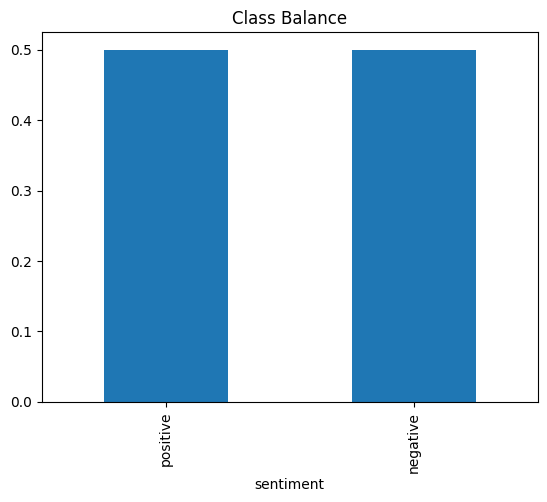

In [4]:
# Basic info
print(f"Dataset shape: {text_df.shape}")
print(text_df.info())
text_df["sentiment"].value_counts(normalize=True).plot(kind="bar", title="Class Balance")

This is a balanced dataset with no missing values. 

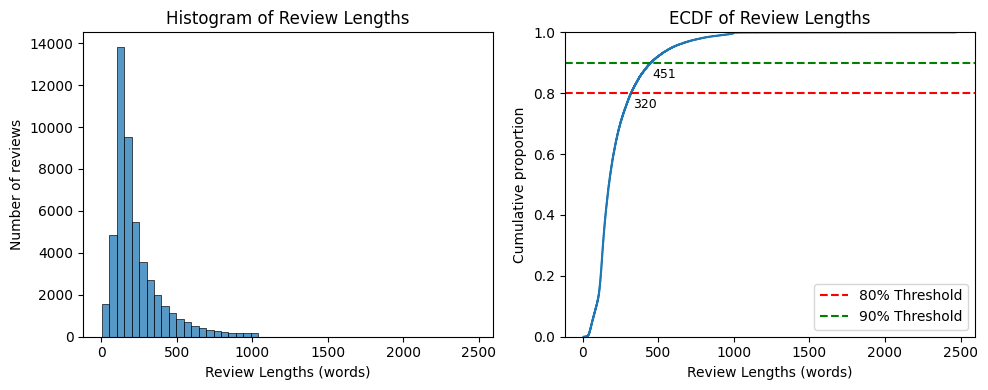

In [5]:
# Adding a column for review length
fig, axes = plt.subplots(1, 2, figsize=(10,4))
text_df["review_length"] = text_df["review"].apply(lambda x: len(str(x).split()))

# histogram of reviews lengths
sns.histplot(text_df["review_length"], bins=50, ax=axes[0])
axes[0].set_title("Histogram of Review Lengths")
axes[0].set_xlabel("Review Lengths (words)")
axes[0].set_ylabel("Number of reviews")

# ECDF plot of review lengths
sns.ecdfplot(data = text_df, x = "review_length", ax=axes[1])
axes[1].set_title("ECDF of Review Lengths")
axes[1].set_xlabel("Review Lengths (words)")
axes[1].set_ylabel("Cumulative proportion")
axes[1].axhline(y=0.8, color="red", linestyle="--", label="80% Threshold")
axes[1].axhline(y=0.9, color="green", linestyle="--", label="90% Threshold")
x_80 = text_df["review_length"].quantile(0.8)
x_90 = text_df["review_length"].quantile(0.9)
axes[1].legend()
# annotating the 80th percentile
axes[1].annotate(f'{x_80:.0f}',
                 xy=(x_80, 0.8),
                 xytext=(x_80 + 10, 0.75),
                 fontsize=9)
# annotating the 90th percentile
axes[1].annotate(f'{x_90:.0f}',
                 xy=(x_90, 0.9),
                 xytext=(x_90 + 10, 0.85),
                 fontsize=9)

plt.tight_layout()
plt.show()

In [6]:
text_df.describe().T.style.set_caption("Descriptive Statistics").format("{:.2f}")

,count,mean,std,min,25%,50%,75%,max
review_length,50000.00,231.16,171.34,4.00,126.00,173.00,280.00,2470.00


In [7]:
# checking for duplicates
text_df.nunique()

review           49582
sentiment            2
review_length     1047
dtype: int64

### Data Integrity Checks

In [8]:
text_df.isnull().sum()

review           0
sentiment        0
review_length    0
dtype: int64

In [9]:
text_df["review"].duplicated().sum()

np.int64(418)

Duplicates need to be dropped at some point

In [10]:
text_df[text_df.duplicated() == True]

,review,sentiment,review_length
3537,Quite what the producers of this appalling ada...,negative,401
3769,My favourite police series of all time turns t...,positive,94
4391,"Beautiful film, pure Cassavetes style. Gena Ro...",positive,110
6352,If you liked the Grinch movie... go watch that...,negative,100
6479,I want very much to believe that the above quo...,negative,446
...,...,...,...
49912,This is an incredible piece of drama and power...,positive,170
49950,This was a very brief episode that appeared in...,negative,199
49984,Hello it is I Derrick Cannon and I welcome you...,negative,417
49986,This movie is a disgrace to the Major League F...,negative,118


In [11]:
text_df_no_duplicates = text_df.drop_duplicates(subset = ["review"],
                                                keep="first")
text_df_no_duplicates.shape

(49582, 3)

### Numeric Features

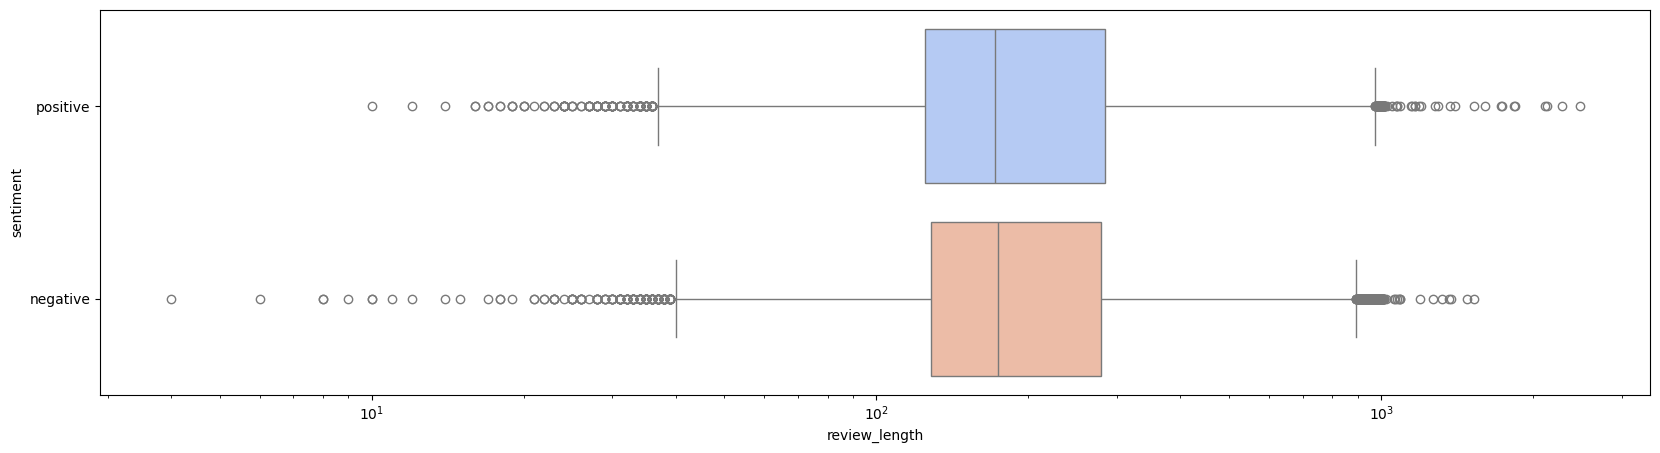

In [12]:
plt.figure(figsize = (20,5))
sns.boxplot(
    data = text_df_no_duplicates,
    x = text_df["review_length"],
    y = text_df["sentiment"],
    palette = "coolwarm",
    log_scale = True
)
plt.show()

### Text features

In [13]:
text_df_no_duplicates.head()

,review,sentiment,review_length
0,One of the other reviewers has mentioned that ...,positive,307
1,A wonderful little production. <br /><br />The...,positive,162
2,I thought this was a wonderful way to spend ti...,positive,166
3,Basically there's a family where a little boy ...,negative,138
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,230


text has html tags

In [14]:
#define clean_text
def clean_text(text):
    text = re.sub(r"<.*?>", " ", text)                   # Remove HTML tags
    text = re.sub(r"http\S+|www\S+", " ", text)          # Remove URLs
    text = re.sub(r"[^\x00-\x7F]+", " ", text)           # Remove non-ASCII
    text = re.sub(r"[_]+", " ", text)                    # Removes underscores
    text = re.sub(r"[^\w\s]", " ", text)                 # Remove punctuation/special chars
    text = re.sub(r"\s+", " ", text)                     # Normalize whitespace
    return text

In [15]:
#test clean_text function
print(clean_text(text_df_no_duplicates.iloc[0, 0]))

One of the other reviewers has mentioned that after watching just 1 Oz episode you ll be hooked They are right as this is exactly what happened with me The first thing that struck me about Oz was its brutality and unflinching scenes of violence which set in right from the word GO Trust me this is not a show for the faint hearted or timid This show pulls no punches with regards to drugs sex or violence Its is hardcore in the classic use of the word It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary It focuses mainly on Emerald City an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda Em City is home to many Aryans Muslims gangstas Latinos Christians Italians Irish and more so scuffles death stares dodgy dealings and shady agreements are never far away I would say the main appeal of the show is due to the fact that it goes where other shows wouldn t dare Forget pretty 

In [16]:
# adding clean review column
text_df_no_duplicates["clean_review"] = text_df_no_duplicates["review"].apply(lambda x: clean_text(x))

In [17]:
# normalising the text data
def preprocess_text(text):
    # 1. Lowercasing
    text = text.lower()
    # 2. Tokenization
    text = re.sub(r"[^\w\s+]", " ", text)
    tokens = nltk.word_tokenize(text)
    # 3. Stop Word Removal
    stop_words = set(stopwords.words("english"))
    tokens = [token for token in tokens if token not in stop_words]
    # 4. Stemming/Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return tokens

In [18]:
# quick test
print(preprocess_text(text_df_no_duplicates.iloc[0, 0]))
print(text_df_no_duplicates.iloc[0, 3])
text_df_no_duplicates.columns

['one', 'reviewer', 'mentioned', 'watching', '1', 'oz', 'episode', 'hooked', 'right', 'exactly', 'happened', 'br', 'br', 'first', 'thing', 'struck', 'oz', 'brutality', 'unflinching', 'scene', 'violence', 'set', 'right', 'word', 'go', 'trust', 'show', 'faint', 'hearted', 'timid', 'show', 'pull', 'punch', 'regard', 'drug', 'sex', 'violence', 'hardcore', 'classic', 'use', 'word', 'br', 'br', 'called', 'oz', 'nickname', 'given', 'oswald', 'maximum', 'security', 'state', 'penitentary', 'focus', 'mainly', 'emerald', 'city', 'experimental', 'section', 'prison', 'cell', 'glass', 'front', 'face', 'inwards', 'privacy', 'high', 'agenda', 'em', 'city', 'home', 'many', 'aryan', 'muslim', 'gangsta', 'latino', 'christian', 'italian', 'irish', 'scuffle', 'death', 'stare', 'dodgy', 'dealing', 'shady', 'agreement', 'never', 'far', 'away', 'br', 'br', 'would', 'say', 'main', 'appeal', 'show', 'due', 'fact', 'go', 'show', 'dare', 'forget', 'pretty', 'picture', 'painted', 'mainstream', 'audience', 'forget'

Index(['review', 'sentiment', 'review_length', 'clean_review'], dtype='object')

### Data Transformation

In [19]:
# encoding categorical variables
text_df_no_duplicates["label"] = text_df_no_duplicates["sentiment"].map({"positive" : 1, "negative" : 0})

# new data frame with labels and tokens
df = text_df_no_duplicates[["clean_review", "label"]]

# splitting data into training and testing sets
review_train, review_test, label_train, label_test = train_test_split(df["clean_review"], df["label"], test_size=0.2, random_state = 42)

## Feature extraction

In [20]:
# Create a TfidVectorizer object
vectorizer = TfidfVectorizer(#tokenizer = preprocess_text,
                             #lowercase = False,
                             min_df = 10,
                             ngram_range=(1,3),
                             max_features = 50000)

# Fit the vectorizer and tranform the reviews into a TF-IDF representation
train_vectors = vectorizer.fit_transform(review_train)
test_vectors = vectorizer.transform(review_test)

# print TF-IDF matrix shape
print(np.shape(train_vectors))
print(np.shape(test_vectors))

(39665, 50000)
(9917, 50000)


In [21]:
# print the vocabulary
print(vectorizer.get_feature_names_out()[:150])

['00' '000' '000 000' '007' '10' '10 000' '10 10' '10 and' '10 because'
 '10 but' '10 for' '10 for the' '10 from' '10 if' '10 is' '10 it'
 '10 lines' '10 minutes' '10 minutes of' '10 of' '10 on' '10 or' '10 out'
 '10 out of' '10 rating' '10 seconds' '10 stars' '10 the' '10 this'
 '10 times' '10 to' '10 year' '10 year old' '10 years' '10 years ago'
 '100' '100 minutes' '100 years' '1000' '101' '11' '11 year' '11 year old'
 '11 years' '12' '12 year' '12 year old' '12 years' '13' '13 year'
 '13 year old' '13th' '14' '14 year' '14 year old' '14 years' '15'
 '15 minutes' '15 minutes of' '15 year' '15 year old' '15 years' '150'
 '16' '16 year' '16 year old' '16mm' '17' '17 year' '17 year old'
 '17 years' '18' '180' '18th' '18th century' '19' '1920' '1920s' '1928'
 '1930' '1930s' '1931' '1932' '1933' '1934' '1935' '1936' '1937' '1938'
 '1939' '1940' '1940s' '1941' '1942' '1943' '1944' '1945' '1946' '1947'
 '1948' '1949' '1950' '1950s' '1951' '1952' '1953' '1954' '1955' '1956'
 '1957' '1958' '

## Training Model

### Logistic Regression

In [22]:
# Train Logistic Regression model as a baseline
lr = LogisticRegression()
lr.fit(train_vectors, label_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [23]:
# making predictions on the test set
predictions = lr.predict(test_vectors)

In [24]:
# Evaluating the model
accuracy = accuracy_score(label_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.9077341938086114


In [25]:
# testing multiple models
#svm_model = SVC()

#lr = LogisticRegression()
##lr.fit(train_vectors, label_train)

#for i in models:
#    if isinstance(i, GaussianNB):
#        i.fit(train_vectors.toarray(), label_train)  # GaussianNB needs dense
#        predictions = i.predict(test_vectors.toarray())
#    else:
#        i.fit(train_vectors, label_train)
#        predictions = i.predict(test_vectors)
#    print(f"Accuracy for {i} model:", accuracy_score(label_test, predictions))

Confusion matrix
[[4421  518]
 [ 397 4581]]


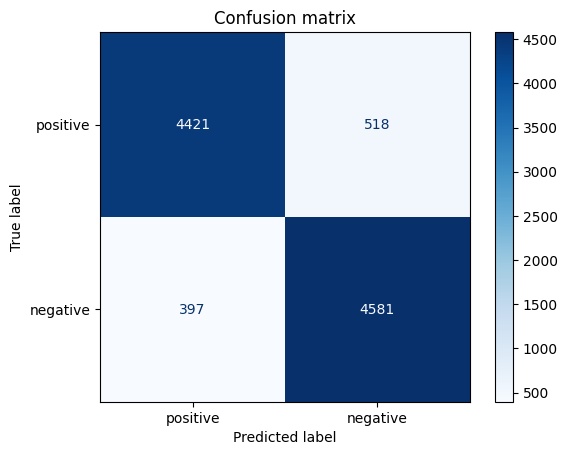

In [26]:
disp = ConfusionMatrixDisplay.from_estimator(
        lr,
        test_vectors,
        label_test,
        display_labels = text_df_no_duplicates.sentiment.unique(),
        cmap = plt.cm.Blues,
    )
disp.ax_.set_title("Confusion matrix")

print("Confusion matrix")
print(disp.confusion_matrix)

plt.show()

- train svm
- evaluate with accuracy /F1/confusion matrix
- make preprocess_data a script
- 

### BERT

In [27]:
# checking for GPU availability
print(torch.__version__)
print(torch.version.cuda)
print(torch.backends.cudnn.version())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CUDA not available")

2.7.1+cu126
12.6
90701
NVIDIA GeForce RTX 3050 Ti Laptop GPU
